## 实战Kaggle比赛：房价预测

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

torch.set_default_tensor_type(torch.FloatTensor)

**获取和读取数据集**

将数据从比赛中下载下来并用pandas读取

In [2]:
train_data = pd.read_csv('../../Datasets/kaggle_house/train.csv')
test_data = pd.read_csv('../../Datasets/kaggle_house/test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

查看前四个样本的前$4$个特征、后$2$个特征和标签：

In [5]:
train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


将训练集和测试集不要$id$那一列按$79$个特征合并

In [6]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


**预处理数据**

对连续数据值得特征值做标准化$（standardization）$：将特征值得每个值先减去均值$\mu$再除以标准差$\sigma$得到标准化后得每个特征值。缺失的特征值用均值替代。

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))
# 标准化时，缺失值填充得时均值，当减去均值后确实值变为0.
# 所以缺失值直接在最后填0即可
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


接下来将离散数值转成指示特征。举个例子，假设特征$MSZoning$里面有两个不同的离散值$RL$和$RM$，那么这一步转换将去掉$MSZoning$特征，并新加两个特征$MSZoning_RL$和$MSZoning_RM$，其值为$0$或$1$。如果一个样本原来在$MSZoning$里的值为$RL$，那么有$MSZoning_RL=1$且$MSZoning_RM=0$。

In [8]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


最后，通过**values**属性得到**NumPy**格式的数据，并转成**Tensor**方便后面的训练。

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float)

**训练模型**

使用一个基本的线性回归模型和平方损失函数来训练模型

In [10]:
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Sequential(
        nn.Linear(feature_num,100),
        nn.ReLU(),
        nn.Linear(100,5),
        nn.ReLU(),
        nn.Linear(5,1),
    )
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

对数均方根误差评价模型

In [11]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2*loss(clipped_preds.log(), labels.log()).mean())
        return rmse.item()

In [12]:
def train(net,train_features,train_labels,test_features,test_labels,epochs,lr,wd,batch_size):
    train_ls, test_ls = [],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    # 使用Adam优化
    optimizer = torch.optim.Adam(params=net.parameters(),lr=lr,weight_decay=wd)
    net = net.float()
    for epoch in range(1,epochs+1):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

**K折交叉验证**

$K$折交叉验证用来选择模型设计并调节超参数。下面实现了一个函数，它返回第$i$折交叉验证时所需要的训练和验证数据。

In [13]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证所需要的训练和验证数据
    assert k>1
    fold_size = X.shape[0]//k
    X_train, t_train = None, None
    for j in range(k):
        # 选择第j折
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]

        if j==i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part),dim=0)
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, epochs, lr, wd, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, epochs, lr, wd, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1,epochs+1),train_ls,'epochs','rmse',range(1,epochs+1),valid_ls,['train','valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k, valid_l_sum/k

fold 0, train rmse 0.578162, valid rmse 0.552907
fold 1, train rmse 0.577051, valid rmse 0.555896
fold 2, train rmse 15.778064, valid rmse 15.784952
fold 3, train rmse 0.572332, valid rmse 0.611690
fold 4, train rmse 0.566940, valid rmse 0.651158
fold 5, train rmse 0.582392, valid rmse 0.513024
fold 6, train rmse 15.786372, valid rmse 15.730931
fold 7, train rmse 0.580796, valid rmse 0.553917
fold 8, train rmse 0.579292, valid rmse 0.534198
fold 9, train rmse 0.576360, valid rmse 0.590259
10-fold validation: avg train rmse 3.617776, avg valid rmse 3.607893


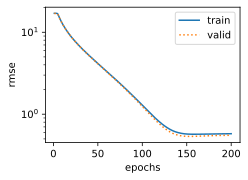

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 10, 200, 0.002, 0.1, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

**预测并产生结果**

In [16]:
def train_and_pred(train_features, test_features, train_labels,
                  test_data, epochs, lr, wd, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                       epochs, lr, wd, batch_size)
    d2l.semilogy(range(1,1+epochs),train_ls,'epochs','rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']],axis=1)
    submission.to_csv('../../Datasets/submission.csv', index=False)

train rmse 0.576410


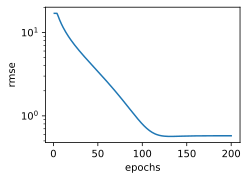

In [17]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)